### Imports

In [1]:
import os
import sys
import os
import torch
from IPython.display import Image, display

sys.path.insert(0, os.path.abspath("src"))

from config import *
from DataManager import DataManager
from AlexNet import AlexNet
from AllenDataLoader import AllenDataLoader
from AllenDataViewer import AllenDataViewer

In [2]:
!bat src/config.py

]10;?]11;?───────┬────────────────────────────────────────────────────────────────────────
       │ File: src/config.py
───────┼────────────────────────────────────────────────────────────────────────
   1   │ import os
   2   │ from pathlib import Path
   3   │ 
   4   │ """Project-wide configuration constants.
   5   │ 
   6   │ All file-system locations are defined with `pathlib.Path` and resolved 
       │ relative
   7   │ to the repository layout to ensure portability and correctness.
   8   │ """
   9   │ 
  10   │ # discover important locations
  11   │ SRC_DIR = Path(__file__).resolve().parent
  12   │ ROOT = SRC_DIR.parent
  13   │ 
  14   │ #? ------------- data constants -------------
  15   │ NEUROPIXELS_PKL_URL: str = "https://mouse-vision-neuraldata.s3.amazonaw
       │ s.com/mouse_neuropixels_visual_data_with_reliabilities.pkl"
  16   │ CALCIUM_PKL_URL: str = "https://mouse-vision-neuraldata.s3.amazonaws.co
       │ m/mouse_calcium_visual_data_with_reliabilities.pkl

In [3]:
# This cell is used for constants override

DOWNLOAD_DATA = False
DOWNLOAD_ALLEN_DATA = False
CONVERT_ALLEN_DATA = False
VISUALIZE_ALLEN_DATA = False

TRAIN = False
TEST = False
LOAD_MODEL = True

### Initialize Data and Model

In [4]:
# detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("Optimizations applied: Mixed Precision, Optimized DataLoader, Larger Batch Size")

data_manager = DataManager(
    data_path=DATA_PATH,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_split=TRAIN_SPLIT,
    val_split=VAL_SPLIT
)
data_manager.setup()

model_manager = AlexNet(
    data_manager=data_manager,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    dropout_rate=DROPOUT_RATE,
    patience=PATIENCE,
    label_smoothing=LABEL_SMOOTHING
)

Using device: cuda
Optimizations applied: Mixed Precision, Optimized DataLoader, Larger Batch Size
Loading dataset from /home/spina/.cache/kagglehub/datasets/arjunashok33/miniimagenet/versions/1
Dataset loaded: 60000 samples, 100 classes
Classes: ['kit fox', 'English setter', 'Siberian husky', 'Australian terrier', 'English springer', 'grey whale', 'lesser panda', 'Egyptian cat', 'ibex', 'Persian cat', 'cougar', 'gazelle', 'porcupine', 'sea lion', 'malamute', 'badger', 'Great Dane', 'Walker hound', 'Welsh springer spaniel', 'whippet', 'Scottish deerhound', 'killer whale', 'mink', 'African elephant', 'Weimaraner', 'soft-coated wheaten terrier', 'Dandie Dinmont', 'red wolf', 'Old English sheepdog', 'jaguar', 'otterhound', 'bloodhound', 'Airedale', 'hyena', 'meerkat', 'giant schnauzer', 'titi', 'three-toed sloth', 'sorrel', 'black-footed ferret', 'dalmatian', 'black-and-tan coonhound', 'papillon', 'skunk', 'Staffordshire bullterrier', 'Mexican hairless', 'Bouvier des Flandres', 'weasel', 

#### Load Model

In [5]:
if LOAD_MODEL:
    if os.path.exists(CHECKPOINT_PATH):
        try:
            model_manager.load_model(CHECKPOINT_PATH)
        except Exception as e:
            print(f"Could not warm-start from {CHECKPOINT_PATH}: {e}")
    else:
        print(f"No checkpoint found at {CHECKPOINT_PATH}")

Model loaded from /home/spina/Desktop/units/DL/project/mice-representation/checkpoints/best_model.pth
Best validation loss: 2.7554
Best validation accuracy: 50.01%


#### Train

In [6]:
if TRAIN:
    print(f"Training")

    #? -------------- Training --------------
    # Train the model
    training_history = model_manager.train()

    # Plot training history
    model_manager.plot_training_history()
    #? ---------------------------------------


### Test

In [7]:
if TEST:
    test_loss, test_accuracy, test_accuracy5 = model_manager.test()

    print(f"Test Results - Loss: {test_loss:.4f}, Acc-Top1: {test_accuracy:.2f}%, Acc-Top5: {test_accuracy5:.2f}%")

### Allen Dataset

In [8]:
dataset = "neuropixels"   # or "calcium"
out = None                # output path for the PKL
path ="AllenData/neuropixels.zarr"               # path to an existing PKL

data_loader = AllenDataLoader(dataset=dataset)

if DOWNLOAD_ALLEN_DATA:
    saved_path = data_loader.download(out_path=out)

INFO:Initialized AllenDataLoader for neuropixels dataset


Convert data to a compatible type

In [9]:
if CONVERT_ALLEN_DATA:
    os.system("REMOVE_ENV=1 src/data/data_converter.sh")

Inspect data

In [10]:
data_viewer = AllenDataViewer(zarr_dir=str(ZARR_NEUROPIXELS))
data_viewer.summary

Dataset opened from: /home/spina/Desktop/units/DL/project/mice-representation/AllenData/neuropixels.zarr
Dims: {'trials': 50, 'frame_id': 118, 'time_relative_to_stimulus_onset': 25, 'units': 8301, 'dim_0': 118, 'dim_1': 918, 'dim_2': 1174}
Variables: ['neural_data', 'stimuli']
stimuli: shape=(118, 918, 1174)
neural_data: shape=(50, 118, 25, 8301)



"Dataset opened from: /home/spina/Desktop/units/DL/project/mice-representation/AllenData/neuropixels.zarr\nDims: {'trials': 50, 'frame_id': 118, 'time_relative_to_stimulus_onset': 25, 'units': 8301, 'dim_0': 118, 'dim_1': 918, 'dim_2': 1174}\nVariables: ['neural_data', 'stimuli']\nstimuli: shape=(118, 918, 1174)\nneural_data: shape=(50, 118, 25, 8301)\n"

Plot a grid of stimuli frames

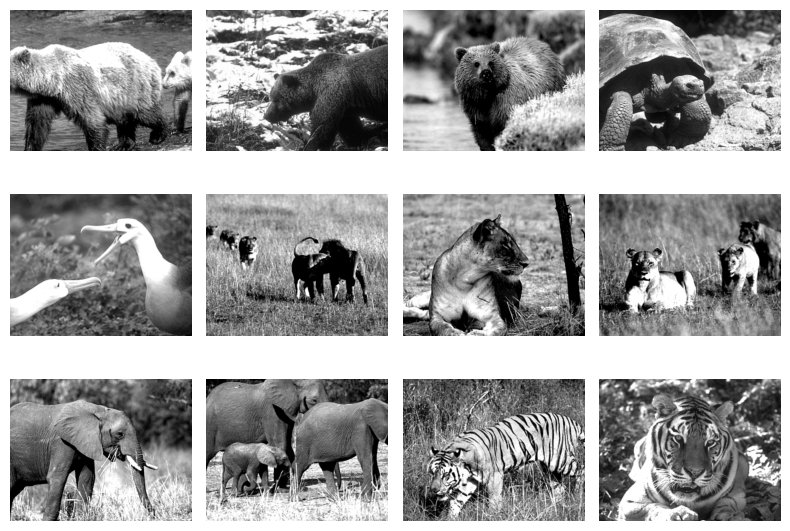

Saved stimuli grid to /home/spina/Desktop/units/DL/project/mice-representation/assets/stimuli_grid.png


In [11]:
stimuli_out = ROOT / Path("assets/stimuli_grid.png")
stimuli_path = data_viewer.plot_stimuli_grid(
    out_path=str(stimuli_out),
    max_images=12,
    show=True
)

Plot a heatmap of neural responses (optionally filtered by visual area)

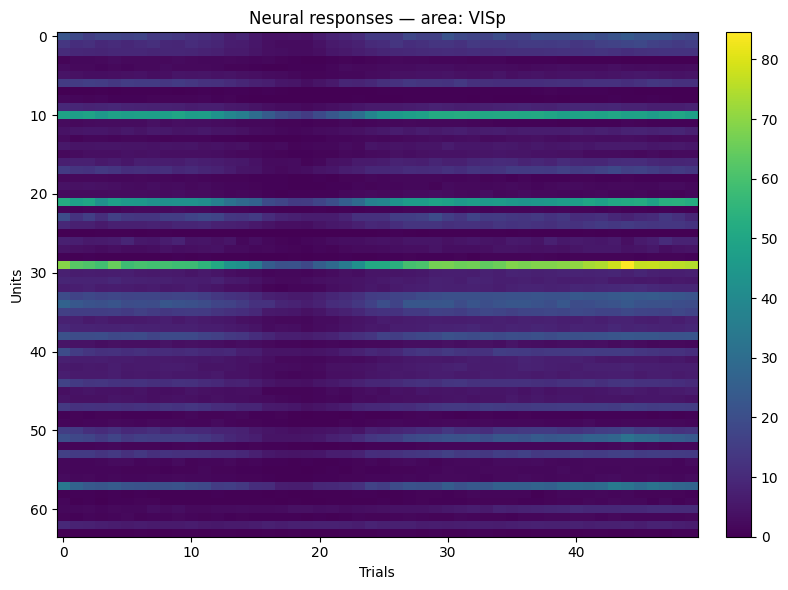

Saved neural responses plot to /home/spina/Desktop/units/DL/project/mice-representation/assets/neural_responses.png


In [12]:
VISUAL_AREA = "VISp"

responses_out = ROOT / Path("assets/neural_responses.png")
responses_path = data_viewer.plot_neural_responses(
    out_path=str(responses_out),
    visual_area=VISUAL_AREA,  # set e.g. "VISp" to filter if coord exists
    max_units=64,             # limit units for readability
    max_trials=100,           # limit trials for readability
    show=True
)

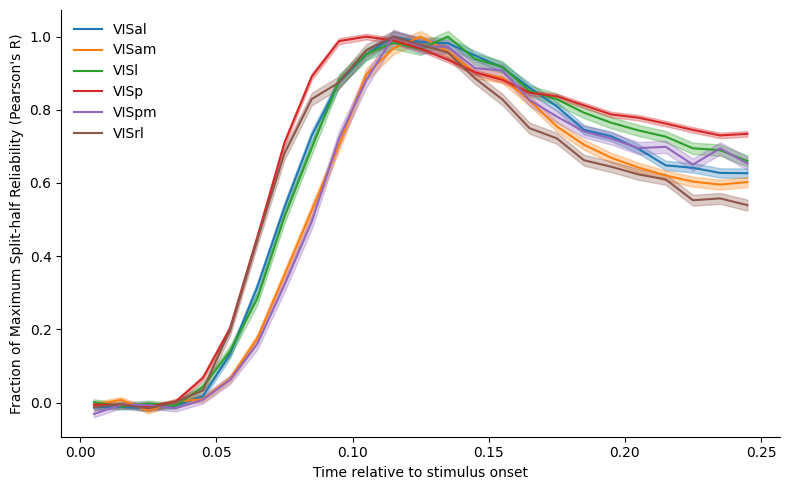

Saved reliability plot to /home/spina/Desktop/units/DL/project/mice-representation/assets/reliability.png


'/home/spina/Desktop/units/DL/project/mice-representation/assets/reliability.png'

In [13]:
reliability_out = ROOT / Path("assets/reliability.png")

data_viewer.plot_neuropixels_reliability(
    out_path=str(reliability_out),
    visual_areas=None,
    fraction_of_max=True,
    time_step_ms=1.0,
    show=True
)